In [2]:
import himalaya.scoring
import matplotlib.pyplot as plt
import simplstyles
import numpy as np
import pandas as pd
import seaborn as sns
from himalaya.backend import set_backend, get_backend
from himalaya.ridge import RidgeCV, GroupRidgeCV

from simulation import generate_dataset

In [3]:
set_backend('cupy', on_error='warn')
backend = get_backend()
plt.style.use('nord-light-talk')

/home/leo/PycharmProjects/compare_variance_residual/venv/lib/python3.12/site-packages/himalaya/backend/_utils.py:55: UserWarning: Setting backend to cupy failed: Cupy not installed..Falling back to numpy backend.
  warnings.warn(f"Setting backend to {backend} failed: {str(error)}."


In [19]:
d_list = [100, 100, 100]
scalars = [1 / 3, 1 / 2, 1 / 6]
n_targets = 10000
n_samples_train = 10000
n_samples_test = 100
n_samples = n_samples_train + n_samples_test
noise_scalar = 0.1

In [5]:
alphas = np.logspace(-5, 5, 10)
cv = 5
score_func = himalaya.scoring.r2_score

In [41]:
Xs, Y = generate_dataset(d_list, scalars, n_targets, n_samples, noise_scalar)

train joint model

In [42]:
banded_solver_params = dict(n_iter=5, alphas=alphas, warn=False, score_func=score_func, n_targets_batch=1000)
joint_model = GroupRidgeCV(groups="input", solver_params=banded_solver_params)

In [43]:
joint_model.fit([x[:n_samples_train] for x in Xs], Y[:n_samples_train])
joint_score = joint_model.score([x[n_samples_train:] for x in Xs], Y[n_samples_train:])
joint_score = backend.to_numpy(joint_score)

[........................................] 100% | 686.23 sec | 5 random sampling with cv | 


Text(0.891266405582428, 0, '0.89')

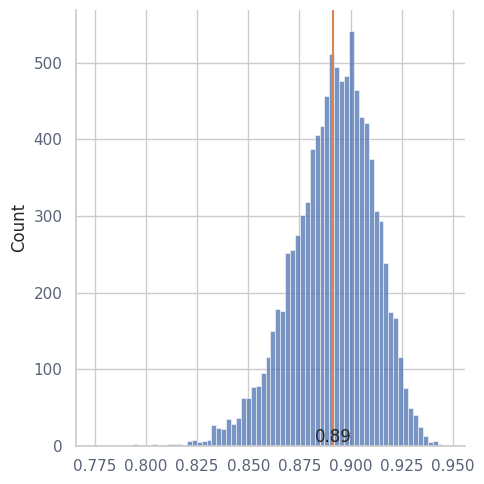

In [44]:
sns.displot(joint_score)
plt.axvline(joint_score.mean(), label="mean", color="C1")
plt.text(joint_score.mean(), 0, f"{joint_score.mean():.2f}", ha='center', va='bottom')

train single models

In [45]:
solver_params = dict(warn=False, score_func=score_func, n_targets_batch=1000)
single_model = RidgeCV(alphas=alphas, cv=cv, solver_params=solver_params)
single_model.fit(Xs[0][:n_samples_train], Y[:n_samples_train])
score_0 = single_model.score(Xs[0][n_samples_train:], Y[n_samples_train:])
score_0 = backend.to_numpy(score_0)

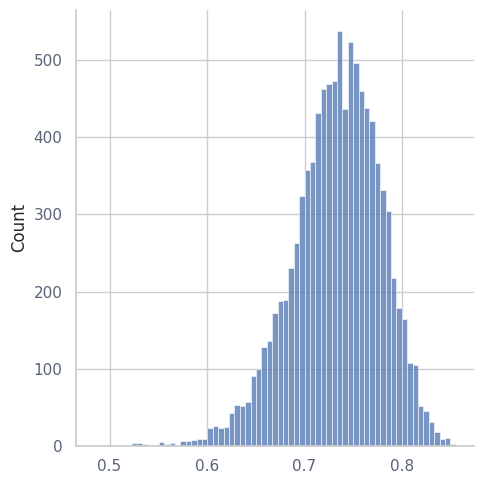

In [46]:
sns.displot(score_0)

In [47]:
solver_params = dict(warn=False, score_func=score_func, n_targets_batch=1000)
single_model = RidgeCV(alphas=alphas, cv=cv, solver_params=solver_params)
single_model.fit(Xs[1][:n_samples_train], Y[:n_samples_train])
score_1 = single_model.score(Xs[1][n_samples_train:], Y[n_samples_train:])
score_1 = backend.to_numpy(score_1)

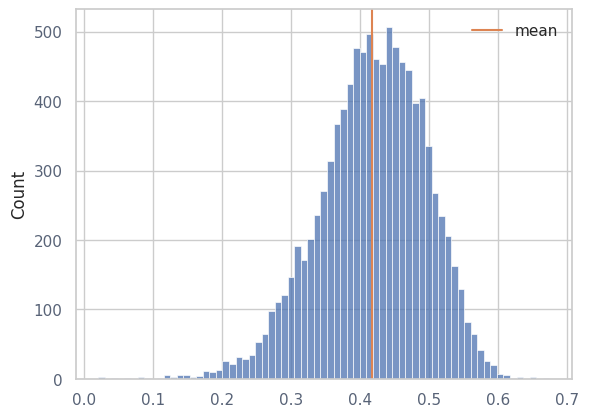

In [48]:
sns.histplot(score_1)
plt.axvline(score_1.mean(), label="mean", color="C1")
plt.legend()

Calculate unique and shared variance

In [49]:
shared = (score_0 + score_1) - joint_score
x0_unique = score_0 - shared
x1_unique = score_1 - shared

In [50]:
shared = backend.to_numpy(shared)
x0_unique = backend.to_numpy(x0_unique)
x1_unique = backend.to_numpy(x1_unique)

create pandas dataset of all scores for analysis

In [20]:
import os

path = os.path.join('results', f'variance_partitioning_{scalars}.csv')
if not os.path.exists(path):
    scores = pd.DataFrame()
    scores[r"$(X_1\cup X_2)\beta \approx Y$"] = joint_score
    scores[r"$X_1\beta \approx Y$"] = score_0
    scores[r"$X_2\beta \approx Y$"] = score_1
    scores[r"$R^2(X_1\beta \approx Y)\cap R^2(X_2\beta \approx Y)$"] = shared
    scores[r"$R^2(X_1\beta \approx Y) \setminus R^2(X_2\beta \approx Y)$"] = x0_unique
    scores[r"$R^2(X_2\beta \approx Y) \setminus R^2(X_1\beta \approx Y)$"] = x1_unique
    scores.to_csv(path)
else:
    scores = pd.read_csv(path)

scores.head()

,Unnamed: 0,$(X_1\cup X_2)\beta \approx Y$,$X_1\beta \approx Y$,$X_2\beta \approx Y$,$R^2(X_1\beta \approx Y)\cap R^2(X_2\beta \approx Y)$,$R^2(X_1\beta \approx Y) \setminus R^2(X_2\beta \approx Y)$,$R^2(X_2\beta \approx Y) \setminus R^2(X_1\beta \approx Y)$
0,0,0.896246,0.726659,0.386552,0.216964,0.509695,0.169588
1,1,0.874849,0.710234,0.440789,0.276173,0.434061,0.164615
2,2,0.938040,0.775402,0.552789,0.390150,0.385252,0.162639
3,3,0.897758,0.721034,0.480114,0.303390,0.417644,0.176724
4,4,0.900779,0.701572,0.341590,0.142383,0.559189,0.199206


In [21]:
renamed_scores = pd.DataFrame()
renamed_scores[r"$[X_1, X_2]\hat{\beta}_{banded ridge}=Y$"] = scores[r"$(X_1\cup X_2)\beta \approx Y$"]
renamed_scores[r"$X_1\hat{\beta}_{ridge}=Y$"] = scores[r"$X_1\beta \approx Y$"]
renamed_scores[r'$X_2\hat{\beta}_{ridge}=Y$'] = scores[r"$X_2\beta \approx Y$"]
renamed_scores[r"$R^2_{shared}$"] = scores[r"$R^2(X_1\beta \approx Y)\cap R^2(X_2\beta \approx Y)$"]
renamed_scores[r"$R^2_{X_{1_{unique}}}$"] = scores[r"$R^2(X_1\beta \approx Y) \setminus R^2(X_2\beta \approx Y)$"]
renamed_scores[r"$R^2_{X_{2_{unique}}}$"] = scores[r"$R^2(X_2\beta \approx Y) \setminus R^2(X_1\beta \approx Y)$"]

renamed_scores.head()

,"$[X_1, X_2]\hat{\beta}_{banded ridge}=Y$",$X_1\hat{\beta}_{ridge}=Y$,$X_2\hat{\beta}_{ridge}=Y$,$R^2_{shared}$,$R^2_{X_{1_{unique}}}$,$R^2_{X_{2_{unique}}}$
0,0.896246,0.726659,0.386552,0.216964,0.509695,0.169588
1,0.874849,0.710234,0.440789,0.276173,0.434061,0.164615
2,0.938040,0.775402,0.552789,0.390150,0.385252,0.162639
3,0.897758,0.721034,0.480114,0.303390,0.417644,0.176724
4,0.900779,0.701572,0.341590,0.142383,0.559189,0.199206


Text(0.0, 1.0, 'Variance Partitioning')

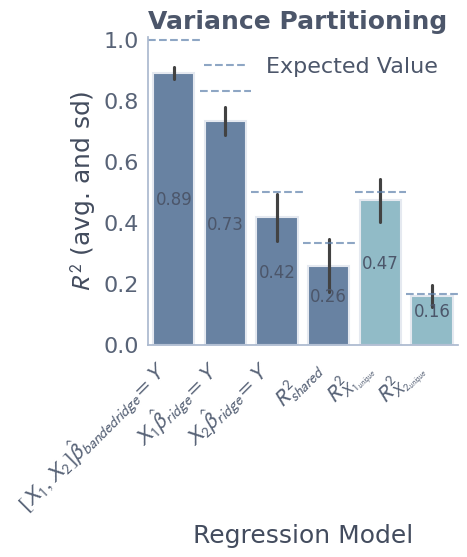

In [22]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.barplot(
    data=renamed_scores,
    palette=["C0", "C0", "C0", "C0", "C1", "C1"],  # Define colors: one for joint/X₁/X₂, one for unique/shared
    ax=ax,
    errorbar='sd',
)
sns.despine(fig)
theoretical_scores = [
    sum(scalars),
    scalars[0] + scalars[1],
    scalars[0] + scalars[2],
    scalars[0], scalars[1],
    scalars[2]
]

# Add lines indicating the maximum possible height for each bar
for idx, column in enumerate(renamed_scores.columns):  # iterate over rows in the DataFrame
    xmin = idx / len(renamed_scores.columns)  # Calculate xmin for each bar
    xmax = (idx + 1) / len(renamed_scores.columns)  # Calculate xmax for each bar
    plt.axhline(theoretical_scores[idx], linestyle='--', alpha=0.7, color='C0',
                xmin=xmin, xmax=xmax, label=fr'Expected Value' if idx == 0 else "")
    plt.text(idx, renamed_scores[column].mean() / 2, f"{renamed_scores[column].mean():.2f}", ha='center', va='bottom', fontsize=12)

plt.xticks(range(len(renamed_scores.columns)), renamed_scores.columns, rotation=45, ha='right')

plt.ylim(0, 1.01)

# Ensure the legend is displayed properly
plt.legend()
plt.ylabel(r"$R^2$ (avg. and sd)")
plt.xlabel(r"Regression Model")
plt.title("Variance Partitioning")

In [56]:
simple_scores = pd.DataFrame()
simple_scores[r"$X_1\cup X_2$"] = scores[r"$(X_1\cup X_2)\beta \approx Y$"]
simple_scores[r"$X_1$"] = scores[r"$X_1\beta \approx Y$"]
simple_scores[r"$X_2$"] = scores[r"$X_2\beta \approx Y$"]

Text(0.5, 0, 'Feature Space')

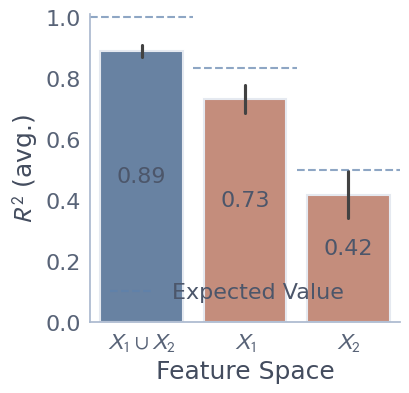

In [62]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.barplot(
    data=simple_scores,
    palette=["C0", "C2", "C2"],  # Define colors: one for joint/X₁/X₂, one for unique/shared
    ax=ax,
    errorbar='sd',
)
sns.despine(fig)
theoretical_scores = [
    sum(scalars),
    scalars[0] + scalars[1],
    scalars[0] + scalars[2],
]

# Add lines indicating the maximum possible height for each bar
for idx, column in enumerate(simple_scores.columns):  # iterate over rows in the DataFrame
    xmin = idx / len(simple_scores.columns)  # Calculate xmin for each bar
    xmax = (idx + 1) / len(simple_scores.columns)  # Calculate xmax for each bar
    plt.axhline(theoretical_scores[idx], linestyle='--', alpha=0.7, color='C0',
                xmin=xmin, xmax=xmax, label=fr'Expected Value' if idx == 0 else "")
    plt.text(idx, simple_scores[column].mean() / 2, f"{simple_scores[column].mean():.2f}", ha='center', va='bottom')

plt.xticks(range(len(simple_scores.columns)), simple_scores.columns)

plt.ylim(0, 1.01)

# Ensure the legend is displayed properly
plt.legend()
plt.ylabel(r"$R^2$ (avg.)")
plt.xlabel(r"Feature Space")
# plt.title("Variance Partitioning")

Text(0.5, 0, 'Feature Space')

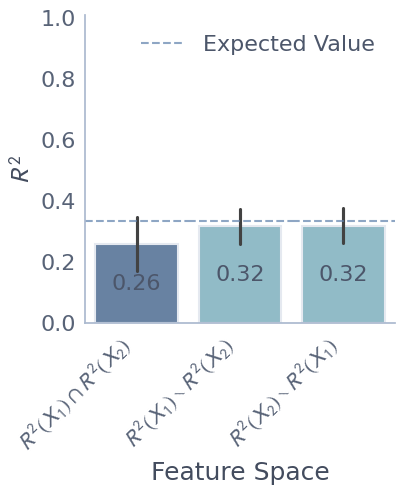

In [73]:
vp_scores = pd.DataFrame()

vp_scores[r'$R^2(X_1)\cap R^2(X_2)$'] = scores[r"$R^2(X_1\beta \approx Y)\cap R^2(X_2\beta \approx Y)$"]
vp_scores[r"$R^2(X_1) \setminus R^2(X_2)$"] = scores[r"$R^2(X_1\beta \approx Y) \setminus R^2(X_2\beta \approx Y)$"]
vp_scores[r"$R^2(X_2) \setminus R^2(X_1)$"] = scores[r"$R^2(X_2\beta \approx Y) \setminus R^2(X_1\beta \approx Y)$"]

fig, ax = plt.subplots(figsize=(4, 4))

sns.barplot(
    data=vp_scores,
    palette=["C0", "C1", "C1"],  # Define colors: one for joint/X₁/X₂, one for unique/shared
    ax=ax,
    errorbar='sd',
)
sns.despine(fig)
theoretical_scores = [
    scalars[0],
    scalars[1],
    scalars[2],
]

# Add lines indicating the maximum possible height for each bar
for idx, column in enumerate(vp_scores.columns):  # iterate over rows in the DataFrame
    xmin = idx / len(vp_scores.columns)  # Calculate xmin for each bar
    xmax = (idx + 1) / len(vp_scores.columns)  # Calculate xmax for each bar
    plt.axhline(theoretical_scores[idx], linestyle='--', alpha=0.7, color='C0',
                xmin=xmin, xmax=xmax, label=fr'Expected Value' if idx == 0 else "")
    plt.text(idx, vp_scores[column].mean() / 2, f"{vp_scores[column].mean():.2f}", ha='center', va='center')

plt.xticks(range(len(vp_scores.columns)), vp_scores.columns, rotation=45, ha='right')


plt.ylim(0, 1.01)

# Ensure the legend is displayed properly
plt.legend()
plt.ylabel(r"$R^2$")
plt.xlabel(r"Feature Space")
# plt.title("Variance Partitioning")

/tmp/ipykernel_4928/363831973.py:3: UserWarning: 
The palette list has fewer values (6) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(


IndexError: list index out of range

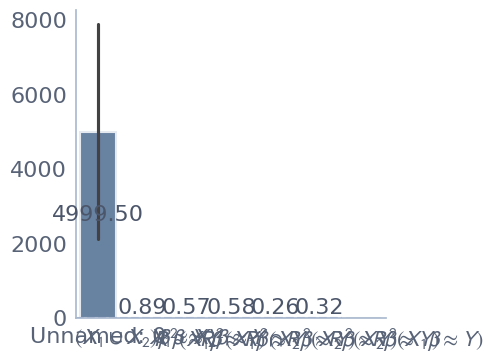

In [74]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.barplot(
    data=scores,
    palette=["C0", "C0", "C0", "C0", "C1", "C1"],  # Define colors: one for joint/X₁/X₂, one for unique/shared
    ax=ax,
    errorbar='sd',
)
sns.despine(fig)
theoretical_scores = [
    sum(scalars),
    scalars[0] + scalars[1],
    scalars[0] + scalars[2],
    scalars[0], scalars[1],
    scalars[2]
]

# Add lines indicating the maximum possible height for each bar
for idx, column in enumerate(scores.columns):  # iterate over rows in the DataFrame
    xmin = idx / len(scores.columns)  # Calculate xmin for each bar
    xmax = (idx + 1) / len(scores.columns)  # Calculate xmax for each bar
    plt.axhline(theoretical_scores[idx], linestyle='--', alpha=0.7, color='C0',
                xmin=xmin, xmax=xmax, label=fr'Expected Value' if idx == 0 else "")
    plt.text(idx, scores[column].mean() / 2, f"{scores[column].mean():.2f}", ha='center', va='bottom')

plt.xticks(range(len(scores.columns)), scores.columns, rotation=45, ha='right')

plt.ylim(0, 1.01)

# Ensure the legend is displayed properly
plt.legend()
plt.ylabel(r"Variance Explained (avg. $R^2$ across targets)")
plt.xlabel(r"Regression Model")
plt.title("Variance Partitioning")